In [1]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocess
import sys

sys.path.append("Python-ELM")
import elm

from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

%matplotlib inline

In [2]:
#Loading data
A = scio.loadmat("tesis_cami/A.mat")["A"]
b = scio.loadmat("tesis_cami/b.mat")["b"]
XDOM = scio.loadmat("tesis_cami/XDOM.mat")["XDOM"]
YDOM = scio.loadmat("tesis_cami/YDOM.mat")["YDOM"]
ZDOM = scio.loadmat("tesis_cami/ZDOM.mat")["ZDOM"]
u = scio.loadmat("tesis_cami/u.mat")["u"]
time = scio.loadmat("tesis_cami/tiempo.mat")["tiempo"]
Su = scio.loadmat("tesis_cami/Su.mat")["Su"]
XDO = scio.loadmat("tesis_cami/XDO.mat")["XDO"]
YDO = scio.loadmat("tesis_cami/YDO.mat")["YDO"]
ZSOL = scio.loadmat("tesis_cami/ZSOL.mat")["ZSOL"]

In [32]:
#Splitting data in different sensors
sensors = ["Arica","Iquique", "Patache", "Mejillones", "DART"]
A_arica,b_arica = A[:961],b[:961]
A_iquique,b_iquique = A[961:961*2],b[961:961*2]
A_patache,b_patache = A[961*2:961*3],b[961*2:961*3]
A_mejillones,b_mejillones = A[961*3:961*4],b[961*3:961*4]
A_dart,b_dart = A[961*4:],b[961*4:]

As = [A_arica,A_iquique,A_patache,A_mejillones,A_dart]
bs = [b_arica,b_iquique,b_patache,b_mejillones,b_dart]

#Time when data comes to the sensor
time_offset = np.array([100,80,100,100,50])
inversion_time = 50

In [33]:
#Stacking all sensor data
AA = []
bb = []

AA_test = []
bb_test = []
for A_i,b_i,title,toffset in zip(As,bs,sensors,time_offset):
    
    #Getting inversion time
    start = toffset
    end = inversion_time*4
    #Separating train with test
    AA.append(A_i[start:end])
    bb.append(b_i[start:end])

    AA_test.append(A_i[end:])
    bb_test.append(b_i[end:])

#Stacking all sensor data
AA = np.vstack(AA)
bb = np.vstack(bb)

In [44]:
preproc = False
if preproc:
    preproc_in =  preprocess.StandardScaler()
    preproc_out = preprocess.StandardScaler()

    AA_preproc = preproc_in.fit_transform(AA)
    bb_preproc = preproc_out.fit_transform(bb)

In [47]:
reg = elm.ELMRegressor(n_hidden=60,activation_func="sigmoid",regressor=Ridge(fit_intercept=False))

if preproc:
    reg.fit(AA_preproc,bb_preproc)
else:
    reg.fit(AA,bb)

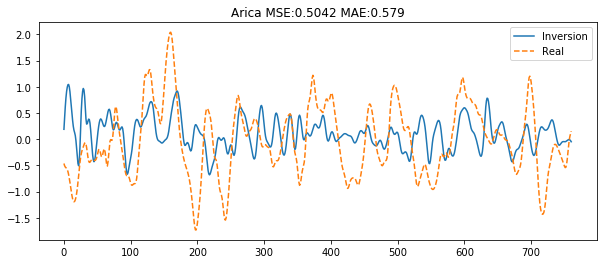

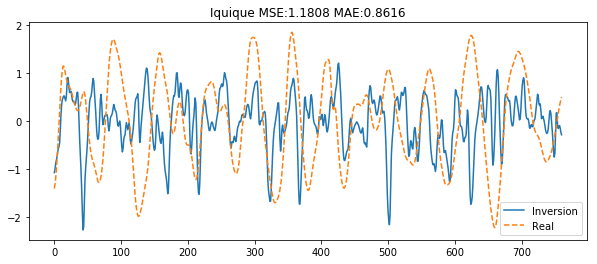

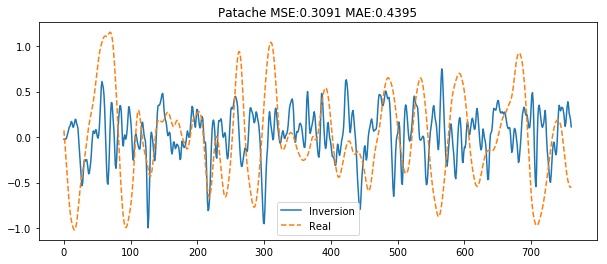

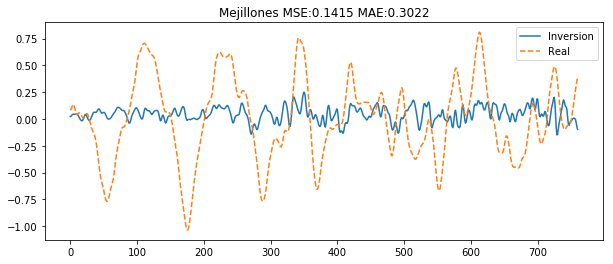

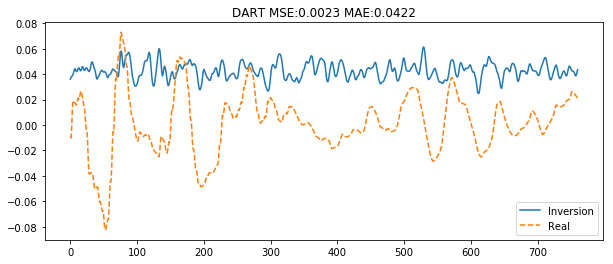

In [48]:
#Plotting solutions with rigde regression
for A_test_i, b_test_i,title in zip(AA_test,bb_test,sensors):
    if preproc:
        b_pred = preproc_out.inverse_transform(reg.predict(preproc_in.transform(A_test_i)))
    else:
        b_pred = reg.predict(A_test_i)
    MSE = round(metrics.mean_squared_error(b_test_i,b_pred),4)
    MAE = round(metrics.mean_absolute_error(b_test_i,b_pred),4)

    plt.figure(figsize=(10,4))
    plt.title("{} MSE:{} MAE:{}".format(title,MSE, MAE))
    plt.plot(b_pred,label="Inversion")
    plt.plot(b_test_i[:,0],"--",label="Real")
    plt.legend()
    plt.show()